# Data

## Reading the data

In [3]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
pass

# Reading train file data
Q1_train = pd.read_csv('Q1_train.csv')
y = Q1_train.to_numpy()[:,0]
x = Q1_train.to_numpy()[:,1:]/256

# Reading test file data
Q1_test  = pd.read_csv('Q1_test.csv')
y_test   = Q1_test.to_numpy()[:,0]
x_test   = Q1_test.to_numpy()[:,1:]/256

print('Train Matrix:\t{}'.format(x.shape))
print('Train Labels:\t{}'.format(y.shape))
print('Test Matrix:\t{}'.format(x_test.shape))
print('Test Labesl:\t{}'.format(y_test.shape))

Train Matrix:	(27455, 784)
Train Labels:	(27455,)
Test Matrix:	(7172, 784)
Test Labesl:	(7172,)


## Plotting some samples

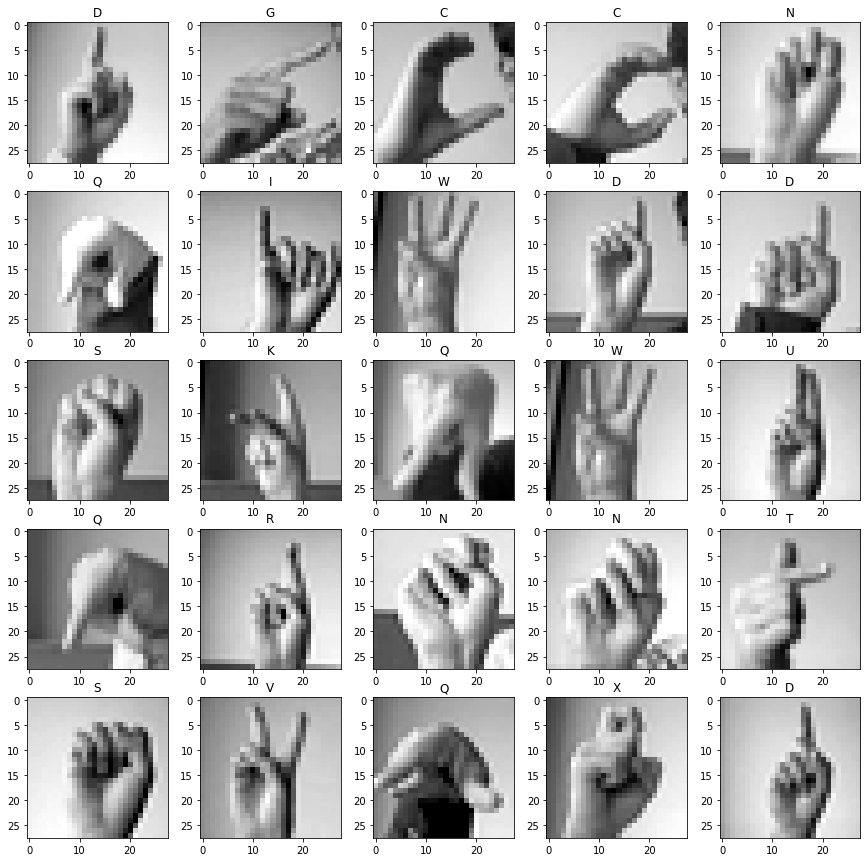

In [4]:
import matplotlib.pyplot as plt

ref = dict()
for i in range(26):
    ref[i] = chr(i+65)

fig, ax = plt.subplots(5,5,figsize=(15,15))

for i in range(5):
    for j in range(5):
        ax[i,j].imshow(np.reshape(x[5*i+j],(28,28)),cmap='gray')
        ax[i,j].set_title(ref[y[5*i+j]])

# Training MLP

## Spliting and one-hotting

In [5]:
from sklearn.model_selection import train_test_split

# Splitting train-valid datasets
ratio = 0.2
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=ratio, shuffle=True, random_state=0)

# Making one-hot labels
n_classes = 25
with tf.Session() as sess:
    y_train_hot = sess.run(tf.one_hot(y_train, n_classes))
    y_valid_hot = sess.run(tf.one_hot(y_valid, n_classes))
    y_test_hot  = sess.run(tf.one_hot(y_test , n_classes))

print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_train:\t{}'.format(x_valid.shape))
print('y_valid:\t{}'.format(y_valid.shape))

x_train:	(21964, 784)
y_train:	(21964,)
x_train:	(5491, 784)
y_valid:	(5491,)


## Examining class labels

In [ ]:
for i in range(np.max(y_train)+1):
    print (f'Samples for class {ref[i]}: {len(np.where(y_train==i)[0])}')

## MLP

### Handful Functions

In [33]:
from tensorboard import program
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def linear(x_in, w, b):
    out = tf.matmul(x_in, w) + b
    return out

def run_tensorboard(log_dir):
    from tensorboard import program
    tb = program.TensorBoard()
    tb.configure(argv=[None, '--logdir', log_dir])
    url = tb.launch()
    print(f"Tensorboard active on {url}")
    return

def show_test_results(net, x_test, y_test):
    y_pred = net.predict(x_test)
    
    print (f'correct predictions:\t{np.sum(y_pred==y_test)} out of {len(y_test)}')
    print (f'test data accuracy:\t{accuracy_score(y_test, y_pred)}\n')
    
    class_names = dict()
    for k,v in ref.items():
        if v != 'J' and v != 'Z':
            class_names[k] = v
            
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(cm_norm,index = class_names.values(), columns = class_names.values())
    figure = plt.figure(figsize=(15, 15))
    sns.heatmap(con_mat_df, annot=True,cmap="YlGnBu")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Test data confusion matrix')
    plt.show()
    return y_pred

### Reset Tensorboard

In [ ]:
!taskkill /IM "tensorboard.exe" /F
!rmdir /S /Q %temp%\.tensorboard-info

### Class Definition

In [19]:
class MLP:
    def __init__(self, layers, dropout=0, activation = tf.nn.relu, optimizer=tf.train.AdamOptimizer, lr=0.001):
        '''
        - layers: the list of neurons in each layer e.g. [784, 256, 64, 10]
            784: input dimension
            256: first hidden layer
            64 : second hidden layer
            10 : number of classes
        - dropout: dropout rate for hidden neurons; default is 0 meaning no dropout
        - activation: activation function for inner layer as function name like tf.nn.relu
        - optimizer: optimizer for training the network as function name like tf.train.GradientDescentOptimizer
        - lr: learning rate of the optimizer
        '''
        
        self.inp = layers[0]
        self.out = layers[-1]
        
        self.layers = layers
        self.depth  = len(layers) # or L-1; not so much differnce
        
        self.weights = dict()
        self.biases  = dict()
        
        self.drop_rate  = dropout # for forward pass
        self.activation = activation
        
        with tf.variable_scope('I/O'):
            self.x_in  = tf.placeholder (dtype=tf.float32, shape=(None,self.inp),name='input')
            self.y_out = tf.placeholder (dtype=tf.float32, shape=(None,self.out),name='output')
            
        with tf.variable_scope('Dropout'):
            self.dout = tf.placeholder (dtype=tf.float32, shape=(),name='dropout')
        
        # ============================================= Here we define the hierarchy in the graph
        self.graph = dict()
        self.graph[0] = self.x_in
        for i in range(1, self.depth):
            
            with tf.variable_scope(f'Layer-{i}-{i+1}'):
                self.weights[i] = tf.get_variable (
                    name = f'W_{i}',dtype = tf.float32,
                    shape = (self.layers[i-1],self.layers[i]),
                    initializer = tf.truncated_normal_initializer(stddev=0.01)
                )
                tf.summary.histogram(f'W_{i}', self.weights[i])

                self.biases[i] = tf.get_variable (
                    name=f'B_{i}', dtype=tf.float32,
                    shape = (self.layers[i],), initializer = tf.zeros_initializer()
                )
                tf.summary.histogram(f'B_{i}', self.biases[i])
                
                if i < self.depth - 1:
                    self.graph[i] = tf.nn.dropout(
                        self.activation(linear(self.graph[i-1],self.weights[i], self.biases[i]))
                        ,rate=self.dout
                    )
                    
                else:
                    self.graph[i] = linear(
                        self.graph[i-1],
                        self.weights[i],
                        self.biases[i]
                    )
        
        # ============================================== Defining handful variables for training
        with tf.variable_scope('Train'):
            
            with tf.variable_scope('Loss'):
                self.loss = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(labels=self.y_out,logits=self.graph[self.depth-1]),
                    name = 'loss'
                    )
                tf.summary.scalar('loss', self.loss)
                
            with tf.variable_scope('Accuracy'):
                self.corr = tf.equal(tf.argmax(self.graph[self.depth-1],1),tf.argmax(self.y_out,1),name='correct')
                self.accuracy = tf.reduce_mean(tf.cast(self.corr, tf.float32), name='accuracy')
                tf.summary.scalar('accuracy', self.accuracy)
            
            with tf.variable_scope('Optimizer'):
                self.opt = optimizer(learning_rate=lr).minimize(self.loss)
        
        # ============================================== Starting session and initialization
        self.sess = tf.InteractiveSession()
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)
        
    def forward(self, X_in):
        
        out = self.sess.run(
            self.graph[self.depth-1],
            feed_dict={self.x_in: X_in, self.dout: self.drop_rate}
        )
        return out
    
    def predict(self, X_in):
        
        pred = self.sess.run(
            self.graph[self.depth-1],
            feed_dict={self.x_in: X_in, self.dout: 0}
        )
        return np.argmax(pred,axis=1)
    
    def train(self, x_train, y_train, x_test, y_test, eps, bs, log_dir='./summaries'):
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter(log_dir, self.sess.graph)
        
        history = {
            'train_loss': list(),
            'train_acc': list(),
            'val_loss': list(),
            'val_acc': list()
        }
        
        step = 0
        for ep in range(1,eps+1):
            if ep % 5 == 0:
                print (f'*** Epoch {ep} ***')
            
            # ============================================ Training Loop
            for i in range(x_train.shape[0]//bs):
                xb = x_train[i*bs: (i+1)*bs]
                yb = y_train[i*bs: (i+1)*bs]
                _ = self.sess.run (
                    self.opt,
                    feed_dict={self.x_in: xb, self.y_out: yb, self.dout: self.drop_rate}
                )                
            
            # ================================================ Training data
            step += 1
            train_summary, loss_train, acc_train = self.sess.run(
                [merged, self.loss, self.accuracy],
                feed_dict={self.x_in: x_train, self.y_out: y_train, self.dout: 0}
            )
            writer.add_summary(train_summary, step)
            if ep % 5 == 0:
                print("training loss: {1:.2f}\ttraining accuracy: {2:.01%}".
                  format(ep, loss_train, acc_train))
            history['train_loss'].append(loss_train)
            history['train_acc'].append(acc_train)
                
            # ================================================ Validation
            loss_valid, acc_valid = self.sess.run(
                [self.loss,self.accuracy],
                feed_dict={self.x_in: x_test, self.y_out: y_test, self.dout: 0}
            )
            
            if ep % 5 == 0:
                print("validation loss: {1:.2f}\tvalidation accuracy: {2:.01%}\n".
                  format(ep, loss_valid, acc_valid))
            history['val_loss'].append(loss_valid)
            history['val_acc'].append(acc_valid)
        
        writer.close()
        
        return history

### Adam

./summaries/20211114-093233
*** Epoch 5 ***
training loss: 0.83	training accuracy: 76.4%
validation loss: 0.86	validation accuracy: 73.8%

*** Epoch 10 ***
training loss: 0.39	training accuracy: 91.1%
validation loss: 0.42	validation accuracy: 90.0%

*** Epoch 15 ***
training loss: 0.20	training accuracy: 96.7%
validation loss: 0.22	validation accuracy: 96.2%

*** Epoch 20 ***
training loss: 0.11	training accuracy: 98.8%
validation loss: 0.11	validation accuracy: 98.6%

*** Epoch 25 ***
training loss: 0.06	training accuracy: 99.4%
validation loss: 0.07	validation accuracy: 99.2%

*** Epoch 30 ***
training loss: 0.04	training accuracy: 99.8%
validation loss: 0.05	validation accuracy: 99.5%

*** Epoch 35 ***
training loss: 0.04	training accuracy: 99.6%
validation loss: 0.04	validation accuracy: 99.3%

*** Epoch 40 ***
training loss: 0.03	training accuracy: 99.7%
validation loss: 0.03	validation accuracy: 99.6%

correct predictions:	5413 out of 7172
test data accuracy:	0.7547406581148912


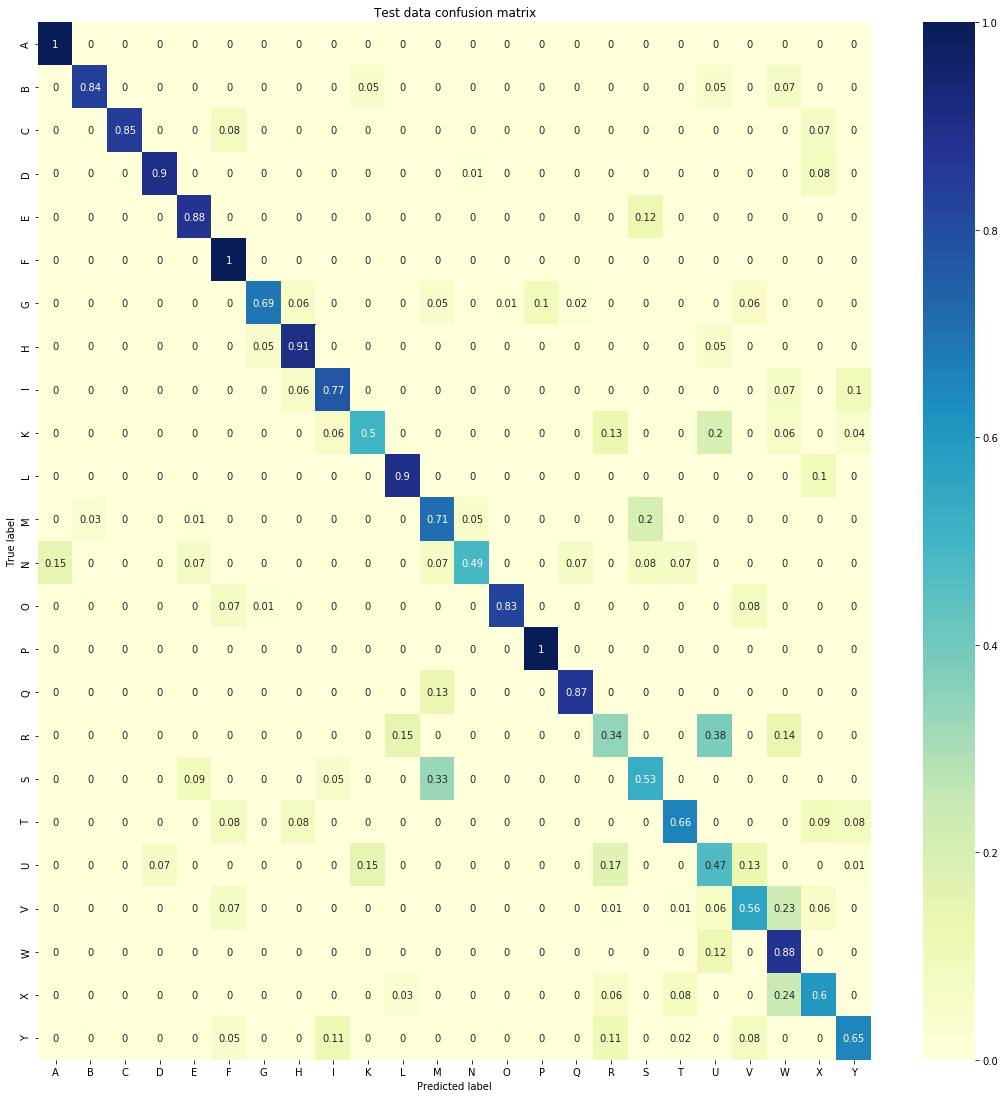

In [40]:
from datetime import datetime

log_dir1 = "./summaries/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print (log_dir1)

tf.reset_default_graph()
net1 = MLP([784,256,25],dropout=0.25) # Adam is the default optimizer

hist1 = net1.train(
    x_train, y_train_hot, 
    x_valid, y_valid_hot,
    eps=40, bs=64,
    log_dir = log_dir1
    )

# ============================== Test
y_pred = show_test_results(net1, x_test, y_test)

#run_tensorboard(log_dir1)

### SGD

*** Epoch 5 ***
training loss: 1.22	training accuracy: 62.1%
validation loss: 1.26	validation accuracy: 60.3%

*** Epoch 10 ***
training loss: 0.62	training accuracy: 82.5%
validation loss: 0.66	validation accuracy: 80.7%

*** Epoch 15 ***
training loss: 0.39	training accuracy: 88.6%
validation loss: 0.42	validation accuracy: 87.5%

*** Epoch 20 ***
training loss: 0.21	training accuracy: 95.1%
validation loss: 0.23	validation accuracy: 94.6%

*** Epoch 25 ***
training loss: 0.13	training accuracy: 97.4%
validation loss: 0.15	validation accuracy: 97.0%

*** Epoch 30 ***
training loss: 0.07	training accuracy: 99.0%
validation loss: 0.08	validation accuracy: 98.8%

*** Epoch 35 ***
training loss: 0.06	training accuracy: 99.1%
validation loss: 0.07	validation accuracy: 98.9%

*** Epoch 40 ***
training loss: 0.04	training accuracy: 99.9%
validation loss: 0.04	validation accuracy: 99.9%

correct predictions:	5569 out of 7172
test data accuracy:	0.7764919129949804



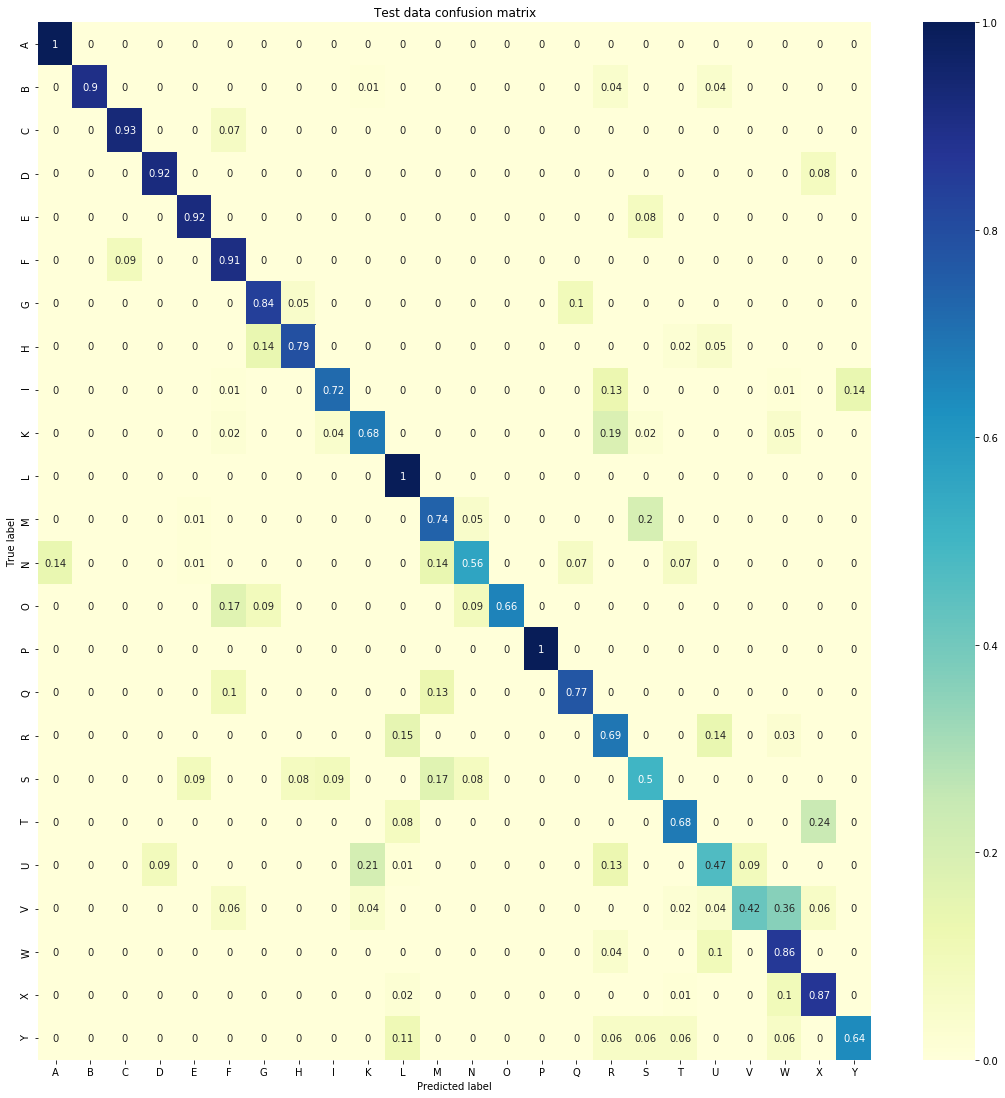

In [38]:
from datetime import datetime
log_dir2 = "./summaries/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tf.reset_default_graph()
net2 = MLP([784,256,25],dropout=0.25,optimizer=tf.train.GradientDescentOptimizer, lr=0.05)

hist2 = net2.train(
    x_train, y_train_hot, 
    x_valid, y_valid_hot,
    eps=40, bs=64,
    log_dir = log_dir2
    )

# ============================== Test
y_pred = show_test_results(net2, x_test, y_test)

#run_tensorboard(log_dir2)

In [39]:
log_dir2

'./summaries/20211114-093038'